In [10]:
import cv2
import imageio
from PIL import Image
import numpy as np
from keras.preprocessing.image import img_to_array
from keras import backend as K
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Convolution2D
from keras.layers import Activation, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
import argparse
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

seed = 42
random.seed = seed

In [2]:
def acc_comp(msk, preds_test_t):

    mean_acc = np.zeros(1)
    mean_TP = np.zeros(1)
    mean_TN = np.zeros(1)
    mean_FP = np.zeros(1)
    mean_FN = np.zeros(1)

    for j in range(msk.shape[0]):
        act = msk[j]
        pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)

        c = act == pr
        d = act & pr
        e = act | pr
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()

        TP = round(float(d.sum()),6)
        FP = round(float(pr.sum()-d.sum()),6)
        TN = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FN = round(float(e.sum()-pr.sum()),6)
        acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)

        mean_TP = np.append([mean_TP],TP)
        mean_TN = np.append([mean_TN],TN)
        mean_acc = np.append([mean_acc],acc)
        mean_FP = np.append([mean_FP],FP)
        mean_FN = np.append([mean_FN],FN)

    mean_acc = mean_acc[1:]
    mean_TP = mean_TP[1:]
    mean_TN = mean_TN[1:]
    mean_FP = mean_FP[1:]
    mean_FN = mean_FN[1:]
    std = round(np.std(mean_acc),6)

    return (mean_acc,std,mean_TP,mean_TN,mean_FP,mean_FN)

class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [3]:
cb = TimingCallback()

In [4]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 2.4 MB/s eta 0:00:00


In [5]:
import patoolib
patoolib.extract_archive("dataset.zip")

INFO patool: Extracting dataset.zip ...
INFO:patool:Extracting dataset.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_27nfnaqf -- dataset.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_27nfnaqf -- dataset.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... dataset.zip extracted to `dataset'.
INFO:patool:... dataset.zip extracted to `dataset'.


'dataset'

In [6]:
TRAIN_PATH = ['dataset/train/images/']
MASK_PATH = ['dataset/train/masks/']
train_ids = next(os.walk(TRAIN_PATH[0]))[2]
mask_ids = next(os.walk(MASK_PATH[0]))[2]
train_ids.sort()
mask_ids.sort()
TRAIN_PATH = TRAIN_PATH*len(train_ids)
MASK_PATH = MASK_PATH*len(train_ids)

In [7]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
sys.stdout.flush()
g = list(range(0,len(train_ids)))
np.random.shuffle(g)
strs_original = ["" for x in range(len(train_ids))]
strs_mask = ["" for x in range(len(train_ids))]
pathmsk = MASK_PATH[0] + mask_ids[0]
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    strs_mask[n] = MASK_PATH[n] + mask_ids[n]
    strs_original[n] = TRAIN_PATH[n] + train_ids[n]

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = strs_original[g[n]]
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

    path = strs_mask[g[n]]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
    if (np.unique(img).size) > 2:
        img = img > 30
    else:
        img = img > 0
    Y_train[n] = img

<ipython-input-7-c71d5ff1ae4d>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/1464 [00:00<?, ?it/s]

<ipython-input-7-c71d5ff1ae4d>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/1464 [00:00<?, ?it/s]

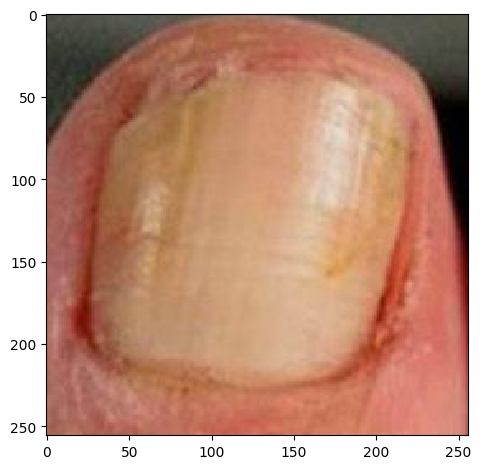

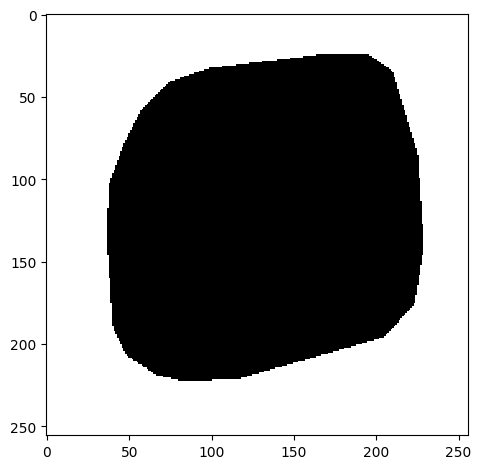

In [8]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [11]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        padding = padding.upper()
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=ksize,
            strides=strides,
            padding=padding)

        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')

            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3])

            ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                                  K.flatten(updates),
                                  [K.prod(output_shape)])

            input_shape = updates.shape
            out_shape = [-1,
                         input_shape[1] * self.size[0],
                         input_shape[2] * self.size[1],
                         input_shape[3]]
        return K.reshape(ret, out_shape)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [14]:
def segnet(input_shape, n_labels, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)


    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_6)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)


    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_8)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)


    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_11)

    # decoder
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)


    unpool_2 = MaxUnpooling2D(pool_size)([conv_14, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_17)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(128, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_21, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    outputs = Activation(output_mode)(conv_26)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

model = segnet((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), n_labels=2, kernel=3, pool_size=(2,2), output_mode="softmax")
print(model.summary())

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_17 (Ba  (None, 256, 256, 64)         256       ['conv2d_17[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_17 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_17[

In [24]:
def dice_coef(y_true, y_pred):

    epsilon=1e-6
    axes = tuple(range(1, len(y_pred.shape)-1))
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)

    return K.mean((numerator + epsilon) / (denominator + epsilon))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [25]:
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['acc', dice_coef])

In [26]:
checkpointer = ModelCheckpoint('model_segnet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.20, batch_size=16, epochs=100, shuffle=True,
                    callbacks=[checkpointer, cb])

Epoch 1/100
 6/74 [=>............................] - ETA: 33s - loss: 0.2798 - acc: 0.4703 - dice_coef: 0.7202

74/74 [==============================] - ETA: 0s - loss: 0.2847 - acc: 0.4999 - dice_coef: 0.7152
Epoch 1: val_loss improved from inf to 0.28463, saving model to model_segnet.h5
74/74 [==============================] - 50s 552ms/step - loss: 0.2847 - acc: 0.4999 - dice_coef: 0.7152 - val_loss: 0.2846 - val_acc: 0.6503 - val_dice_coef: 0.7159
Epoch 2/100
74/74 [==============================] - ETA: 0s - loss: 0.2847 - acc: 0.4952 - dice_coef: 0.7148
Epoch 2: val_loss did not improve from 0.28463
74/74 [==============================] - 41s 560ms/step - loss: 0.2847 - acc: 0.4952 - dice_coef: 0.7148 - val_loss: 0.2847 - val_acc: 0.6485 - val_dice_coef: 0.7159
Epoch 3/100
74/74 [==============================] - ETA: 0s - loss: 0.2847 - acc: 0.4756 - dice_coef: 0.7155
Epoch 3: val_loss did not improve from 0.28463
74/74 [==============================] - 40s 535ms/step - loss: 0.2847 - acc: 0.4756 - dice_coef: 0.7155 - val_loss: 0.2856 - val_acc: 0.6357 - val_dice_coef: 0.7150
Epoch 4/10

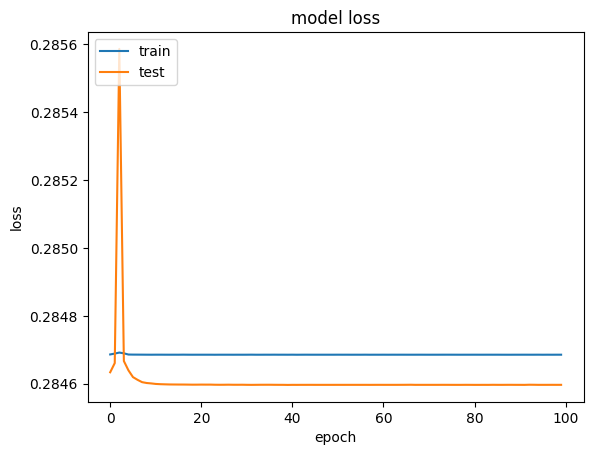

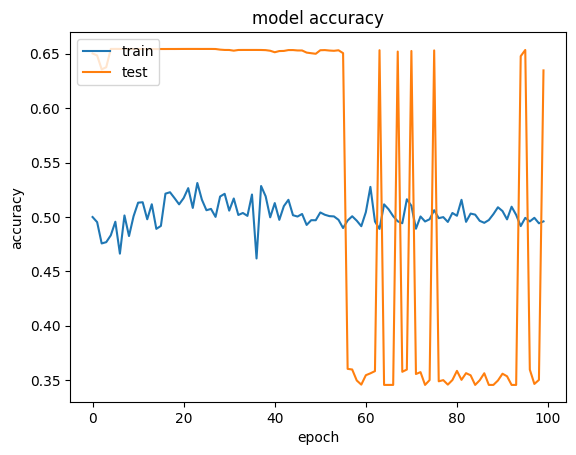

SEGNET ARCHITECTURE
-------------------------------------------------------------
Total num of training images: 1464
Max num of epochs: 50
Optimizer: ADAM
Batch size: 64
Loss function: Binary Cross-Entropy
Validation data percentage: 10


In [27]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("SEGNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)

a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]

In [32]:
model = load_model('model_segnet.h5', custom_objects={'mean_iou': mean_iou, 'MaxPoolingWithArgmax2D': MaxPoolingWithArgmax2D,
                                                      'MaxUnpooling2D': MaxUnpooling2D, 'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

10/10 [==============================] - 3s 310ms/step


In [35]:
model = load_model('model_segnet.h5', custom_objects={'mean_iou': mean_iou, 'MaxPoolingWithArgmax2D': MaxPoolingWithArgmax2D,
                                                      'MaxUnpooling2D': MaxUnpooling2D, 'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
ABD_PATH = 'dataset/train/images/'
MSK_PATH = 'dataset/train/masks/'

abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
msk = np.zeros((len(msk_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img

for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):
    path = MSK_PATH + id_
    img = imread(path)

    if img.ndim >= 3:
        img = img[:,:,1]

    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True)
    if (np.unique(img).size) > 2:
        img = img > 30           # Important, Needed to make labels 0's and 1's only
    else:
        img = img > 0
    img = img.astype(np.uint8)
    msk[n] = img

preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)

answer = acc_comp(msk, preds_test_t);

<ipython-input-35-bb0e8fa76db6>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):


  0%|          | 0/1464 [00:00<?, ?it/s]

<ipython-input-35-bb0e8fa76db6>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):


  0%|          | 0/1464 [00:00<?, ?it/s]

46/46 [==============================] - 16s 327ms/step


ValueError: cannot reshape array of size 131072 into shape (256,256)

In [ ]:
for j in range(10):
    plt.show()
    imshow(abd[j])
    plt.show()
    imshow(np.squeeze(preds_test_t[j]*255))
    plt.show()
    imshow(np.squeeze(msk[j]))